# **Anomaly Detection in Network Traffic with K-means clustering**
We can categorize machine learning algorithms into two main groups: supervised learning and unsupervised learning. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called clusters. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well known clustering algorithm to detect anomaly network connections based on statistics about each of them. For a thorough overview of K-means clustering, from a research perspective, have a look at this wonderful tutorial.

# Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

# Steps
1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unsual connections.

# **1. K-means**
# **1.1. Introduction**
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of  k , it tries to build  k  clusters from samples in the dataset. Therefore,  k  is an hyperparameter of the model. The right value of  k  is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measue the similarity between any two data points, K-means requires the definition of a distance funtion between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a  d -dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a  d -dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

# **1.2. How does it work ?**
Given  k , the K-means algorithm works as follows:

1. Randomly choose  k  data points (seeds) to be the initial centroids
2. Assign each data point to the closest centroid
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result. From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centres of those runs and input the centres as initial ones for one final run of the analysis.

# **1.3. Illustrative example**
One of the best ways to study an algorithm is trying implement it. In this section, we will go step by step to implement a simple K-means algorithm.

Use the below function to calculate an euclidean distance between any two points in  d -dimensional data space.

In [0]:
import numpy as np

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    # Square root the sum of (c1 - c2)^2 where c1 and c2 derive from the zip of p1, p2.
    # What is a zip?
    return np.sqrt(np.sum([(c1 - c2)**2 for c1, c2 in zip(p1, p2)]))

# test our function
#     Telling the program to test the condition and trigger an error if it is false.
#         Try - Throw - Catch relationship in C++
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

Given a data point and the current set of centroids, use the function below to find the index of the closest centroid for that data point.

In [0]:
def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    return min(enumerate(centroids), key=lambda x: euclidean_distance(datapoint, x[1]))[0]

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"

Use the function below to randomize  k  initial centroids.

In [0]:
np.random.seed(22324) #Seed pushed through or chosen randomly?  What is 22324?

# randomize initial centroids
def randomize_centroids(data, k):
    print("This is the data:")
    print(data, "\n")
    # length of data indicates the random indices.
    # random_indices is an array based off the col/row length of the matrix (0, 1, 2) because matrix is 3x3.
    random_indices = np.arange(len(data))
    print("These are the random indices: %", random_indices, "\n")
    # Shuffles the indices saved in the vector.
    np.random.shuffle(random_indices)
    print("These are the shuffled indices: %", random_indices, "\n")

    random_indices = random_indices[:k]
    print("These are the indices cut by k: %", random_indices, "\n")
    centroids = [data[i] for i in range(len(data)) if i in random_indices]
    return centroids

assert(len(
    randomize_centroids(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"

This is the data:
[[2 1 2]
 [1 2 1]
 [3 1 2]] 

These are the random indices: % [0 1 2] 

These are the shuffled indices: % [1 0 2] 

These are the indices cut by k: % [1 0] 



Use function check_converge to check the stop creteria of the algorithm.

In [0]:
MAX_ITERATIONS = 10

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if num_iterations > MAX_ITERATIONS:
        return True
    # check if the centroids don't move (or very slightly)
    #     zip() has the purpose to map the similar index of multiple
    #          containers so that they can be used as a single entity.
    distances = np.array([euclidean_distance(c, o) for c, o in zip(centroids, old_centroids)])
    if (distances <= threshold).all():
        return True
    return False

Use function update_centroid to update the new positions for the current centroids based on the position of their members.

In [0]:
# centroids: a list of centers
# clusters: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, clusters):
    assert(len(centroids) == len(clusters))
    clusters = np.array(clusters)
    for i, cluster in enumerate(clusters):
        centroids[i] = sum(cluster)/len(cluster)
    return centroids

Use the K-means algorithm scheleton below, with the functions you wrote above.

In [0]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):
    
    data = np.array(data)
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for datapoint in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(datapoint, centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(datapoint)
        
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        
        # update centroids
        centroids = update_centroids(centroids, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations):
            break
    
    return centroids

Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

This is the data:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5

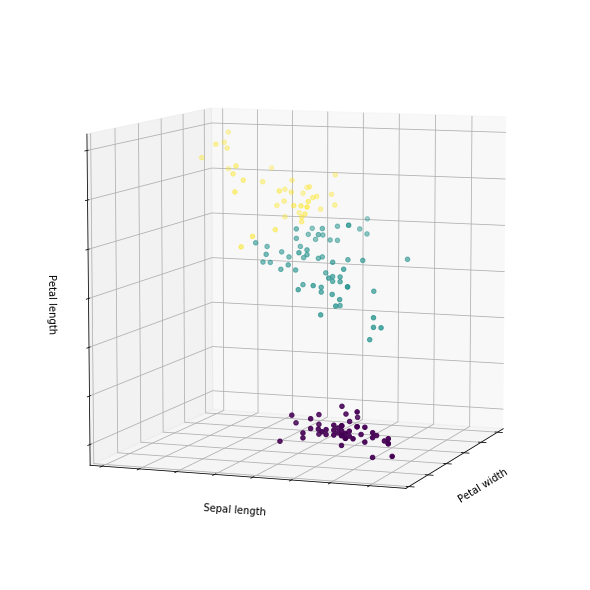

In [0]:
# the sourcecode in this cell is inspired from 
# https://gist.github.com/bbarrilleaux/9841297

%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)

# moon
# np.random.seed(0)
# X, y = datasets.make_moons(2000, noise=0.2)

# blob
# np.random.seed(0)
# X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

# centers = kmeans(X, k=3)
# labels = [find_closest_centroid(p, centers) for p in X]

# fig = plt.figure(1, figsize=(8, 8))
# plt.clf()
# plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

plt.show()

# Here we use sci-kit learn implementation of K-means
# centers =cluster.KMeans(n_clusters=3)
# centers.fit(X_iris) 
# labels = centers2.labels_

# **2. Usecase: Network Intrusion**
Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.

# **2.1. Data**
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each features, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as su_attempted in the 15th column. Some features are counts, like num_file_creations in the 17th columns. Some others are the number of sent and received bytes.

# **2.2. Clustering without using categorical features**
First, we need to import some packages that are used in this notebook.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import os
import sys
import re
import time
from pyspark import SparkContext as sc
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
# from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from operator import add
from pyspark.mllib.clustering import KMeans, KMeansModel
from operator import add
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
import itertools

input_path = "/content/kddcup.data"
#input_path = "/content/kddcup.data_10_percent_corrected"
#Currently using data_10%.  If full data set used, extra points!
raw_data = spark.sparkContext.textFile(input_path, 12)


# **2.2.1. Loading data**
There are two types of features: numerical features and categorical features. Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1:** we don't use the labels in the training phase !!!

**Note 2:** in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

# **Question 1**
Write function parseLine to construct a tuple of (label, vector) for each connection, extract the data that contains only the data points (without label), then print the number of connections.

Where,

* label is the pre-defined label of each connection
* vector is a numpy array that contains values of all features, but the label and the categorial features at index 1,2,3 of each connection. Each vector is a data point.

In [0]:
def parseLine(inData):
  '''
  Given a line of raw_data with direction on format,
  this function will return a tuple of (label, vector).
  Removing categorical features means skipping indexes 1 through 3.
  >> tcp   -> 1
  >> http  -> 2
  >> SF    -> 3
  (may need to remove ending value also "normal")

  Label  --> pre-defined label of each connection.
  Vector --> NumPy array containing values of all features; data point.

  Format of raw_data:
  >> Columns act as the labels.
  >> Vectors consist of columns, minus the identifier (label)
  >> Lines are split at the comma (',')
  '''
  columns = inData.split(',')
  label = columns[-1]

  vector = columns[:-1]
  vector = [d for i, d in enumerate(vector) if i not in [1, 2, 3]]
  vector = np.array(vector, dtype = np.float) # ensure var is stored as a float

  return (label, vector)

In [0]:
#To ensure readout is correct later.
#n = raw_data.count()
#print(n)

lnd = raw_data.map(parseLine).cache()     #labels and data
d = lnd.map(lambda row: row[1]).cache()   #remove labels
#print(d)

connections = d.count() #how many connections there are
print("There are", connections, "connections.")

#verify the number of features
#f = len(d.first())
#print("There are % features.", f)

There are 214919 connections.


# **Question 2**
Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

You can use the following parameters:

* maxIterations=10
* runs=10
* initializationMode="random"
Discuss the result from your figure.

In [0]:
time_test = time.time()
clusters = KMeans.train(d, 2, maxIterations = 10, runs = 10, initializationMode = "random")
#model = clusters.fit(raw_data)
print("This took time: ", (time.time() - time_test))

#pick the features with the highest variance
m = d.reduce(add) / connections
fvar = d.map(lambda x: (x -  m) ** 2).reduce(add) / connections

#chosing features with most variance.
chosenF = [t[0] for t in sorted(enumerate(fvar), key = lambda x: x[1])[-3:]]

#select small slice of data for plotting.
plotD = d.randomSplit([10, 90])[0]

#create two sets of data
clust0 = d.filter(lambda point: clusters.predict(point) == 0)
clust1 = d.filter(lambda point: clusters.predict(point) == 1)

#format data sets into clusters
cent0 = clusters.centers[0]
cent1 = clusters.centers[1]
cluster0 = clust0.take(5)
cluster1 = clust1.take(5)

#format clusters to be plotted
plot0 = np.array([[point[i] for i in chosenF] for point in cluster0])
plot1 = np.array([[point[i] for i in chosenF] for point in cluster1])

#Extremes to identify plot area
MAX = max(max(plot0.flatten()), max(plot1.flatten()))
MIN = min(min(plot0.flatten()), min(plot0.flatten()))

/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


This took time:  2.977555513381958


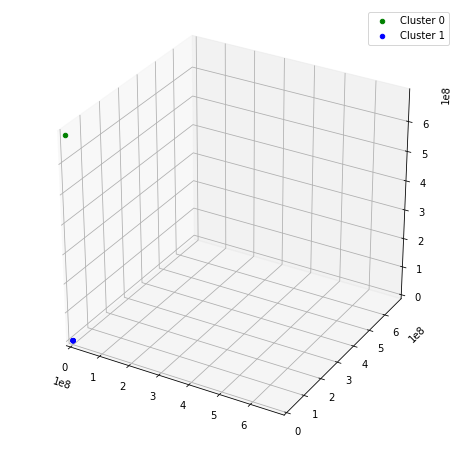

In [0]:
#plotting the clusters

fig = plt.figure(figsize = (8, 8))

#dictate that the plot will be a 3D representation of the data
#needed to install "from mpl_toolkits.mplot3d import Axes3D" in order to plot
axis = fig.add_subplot(111, projection = '3d')

axis.scatter(plot0[:, 0], plot0[:, 1], plot0[:, 2], c = "g")  #set points to green
axis.scatter(plot1[:, 0], plot1[:, 1], plot1[:, 2], c = "b")  #set points to blue

#set graph limits using MAX and MIN
axis.set_xlim(MIN, MAX)
axis.set_ylim(MIN, MAX)
axis.set_zlim(MIN, MAX)

#Legend to identify what the plots are
axis.legend(["Cluster 0", "Cluster 1"])

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center. 
We will now use a version of euclidean_distance that assumes the arguments to be numpy arrays, which is really faster, it will come to be useful because this function will be use several million times.

In [0]:
def euclidean_distance(a, b):
    c = a - b
    return np.sqrt(c.T.dot(c))

In [0]:
from operator import add
t1 = time.time()
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return euclidean_distance(closest_center, point)**2

WSSSE = d.map(lambda point: error(clusters, point)).reduce(add)
print("Within Set Sum of Squared Error = " + str(WSSSE))
print(time.time() - t1)

Within Set Sum of Squared Error = 2156162589568904.2
4.178010702133179


# **Question 3**
This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Use the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs. What do you think about the result ?

In [0]:
clusterLabelCount = lnd.map(lambda row: ((clusters.predict(row[1]), row[0]), 1)).reduceByKey(add)

for item in clusterLabelCount.collect():
    print(item)

((1, 'normal.'), 71225)
((1, 'warezmaster.'), 20)
((1, 'rootkit.'), 7)
((1, 'warezclient.'), 1020)
((1, 'perl.'), 2)
((1, 'land.'), 17)
((1, 'phf.'), 3)
((1, 'portsweep.'), 638)
((1, 'spy.'), 2)
((1, 'buffer_overflow.'), 12)
((1, 'ftp_write.'), 8)
((1, 'satan.'), 1587)
((1, 'neptune.'), 41122)
((1, 'pod.'), 102)
((1, 'teardrop.'), 397)
((1, 'smurf.'), 95480)
((1, 'ipsweep.'), 862)
((1, 'imap.'), 12)
((0, 'portsweep.'), 1)
((1, 'nmap.'), 231)
((1, 'multihop.'), 7)
((1, 'back.'), 2103)
((1, 'loadmodule.'), 8)
((1, 'guess_passwd.'), 53)


**COMMENT HERE**

There doesn't seem to be a lot of balance here.  The numbers are all over the place, leading me to believe that the KMeans used above isn't working for this dataset.  This can happen when one cluster has more data points than another, or if the data in one cluster is significantly higher or lower than the other cluster.  Based on this, the graph above also comes into question as being unusual or at least not what we want when evaluating a dataset.

Solution is to find a better k value for the KMeans training function.

# **2.2.4. Choosing K**
How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of  k . For doing that, we have to build and evaluate models with different values of  k . A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

# **Question 4**
Use the function below to calculate the MSE of each model that is corresponding to each value of  k . Plot the results. From the obtained result, what is the best value for  k  ? Why ?

/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


136374791045432.2
100878309108832.95
96318665503051.45
90503791852923.53
89441660898569.16
93475287448186.72
103971452644086.11


Text(0, 0.5, 'clustering score')

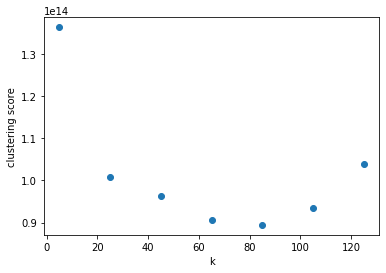

In [0]:

# k: the number of clusters
k_range = range(5, 126, 20)

def clusteringScore(data, k):
    clusters = KMeans.train(d, k, maxIterations=10, runs=10, initializationMode="random")
    # calculate mean square error
    WSSSE = d.map(lambda point: error(clusters, point)).reduce(add)
    #WSSSE = clusters.computeCost(data)
    return WSSSE

scores = [clusteringScore(d, k) for k in k_range]
for score in scores:
    print(score)
    
# plot results
plt.scatter(k_range, scores)
plt.xlabel('k')
plt.ylabel('clustering score')

**COMMENT HERE**

*For 10% of the Dataset*
Based on the above graph, the best k value appears to be between 80 and 90.  The reason this appears to be the case is that k-means go up but cluster score goes down lowest at this point.  Running further, tighter, tests should help determine the best k-means value from within this scope.

*For Full Dataset*
Here it appears that the best point for k means is between 80 and 90.

/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


93294313887821.83
106388597012286.56
96242070730992.89
90639465079275.08
88408150417429.5
100007188544827.47
96308390205838.47
88972690201527.28
115257006456634.42
89046742788760.58


Text(0, 0.5, 'clustering score')

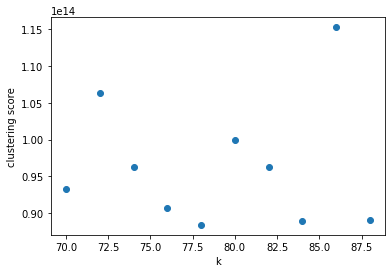

In [0]:
'''
Attempt at finding the best point based on comment above.
k: the number of clusters

finding a k_range is finding the range from point a to b; incrementing by c.
'''
k_range = range(70, 90, 2)  # Increment from 75 to 95, incrementing by 2

def clusteringScore(data, k):
    clusters = KMeans.train(d, k, maxIterations=10, runs=10, initializationMode="random")
    # calculate mean square error
    WSSSE = d.map(lambda point: error(clusters, point)).reduce(add)
    #WSSSE = clusters.computeCost(data)
    return WSSSE

scores = [clusteringScore(d, k) for k in k_range]
for score in scores:
    print(score)
    
# plot results
plt.scatter(k_range, scores)
plt.xlabel('k')
plt.ylabel('clustering score')

*Full Dataset*

By going deeper into this area of k-mean values, we can see a scater of cluster score vs k value.  The lowest point here appears to be between 77.5 and 80.0.  As we are incrementing by values of 2 for this run, it appears that 78.0 is the best value here for the Full Dataset.  That being said, there is a lot of movement here. It's possible this is a local optimum and not a global optimum.  Broader runs with a lower increment than the first run of the sample may allow for a better k-means value being indicated.

# **2.2.5 Normalizing features**
K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias.

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation
\begin{align}
normalize_i=\frac{feature_i - \mu_i}{\sigma_i}
\end{align}
Where,
* $normalize_i$  is the normalized value of feature $i$ 
* $\mu_i$ is the mean of feature $i$ 
* $\sigma_i$ is the standard deviation of feature $i$

# **Question 5**
Complete the code below to normalize the data. Print the first 5 lines of the new data.

HINT: If $\sigma_i=0$ then ${normalize}_i = {feature}_i−\mu_i$

In [0]:
def normalizeData(d):
    # number of connections
    connections = d.count()
    m = d.reduce(add) / connections
    fvar = d.map(lambda x: (x - m) ** 2).reduce(add) / connections
    stdevs = np.sqrt(fvar)
    # if == 0 than = 1
    stdevs[stdevs == 0] = 1

    def normalize(point):
        return (point - m) / stdevs
    return d.map(normalize)


result = normalizeData(d).cache()
print(result.take(2))
print(d.take(2))

[array([-0.04040558, -0.00388644,  0.07554   , -0.00889415, -0.04591305,
       -0.00389869, -0.06377014, -0.01469604,  1.56246339, -0.0092935 ,
       -0.01364373, -0.00611934, -0.00795809, -0.01539692, -0.01235814,
       -0.03650866,  0.        ,  0.        , -0.05237767, -1.13460574,
       -0.90670976, -0.49115263, -0.49047575, -0.16321854, -0.16488534,
        0.50123862, -0.22653729, -0.28372458, -2.43634082, -1.7532261 ,
        0.57655703, -0.27153977, -0.77381379, -0.23367452, -0.49173739,
       -0.48979079, -0.16933047, -0.16505936]), array([-0.04040558, -0.00384773, -0.0258431 , -0.00889415, -0.04591305,
       -0.00389869, -0.06377014, -0.01469604,  1.56246339, -0.0092935 ,
       -0.01364373, -0.00611934, -0.00795809, -0.01539692, -0.01235814,
       -0.03650866,  0.        ,  0.        , -0.05237767, -1.13460574,
       -0.90670976, -0.49115263, -0.49047575, -0.16321854, -0.16488534,
        0.50123862, -0.22653729, -0.28372458, -2.3168957 , -1.65668882,
        0.57655

# **Question 6**
Using the new data, build different models with different values of $k\in [60,70,80,90,100,110]$ . Evaluate the results by plotting them and choose the best value of $k$.

/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


88548733294930.45
89773811273850.83
91821024699564.4
86457344739604.66
89695471602014.7


Text(0, 0.5, 'clustering score')

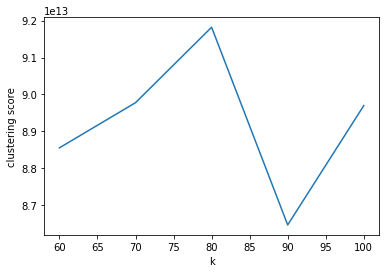

In [0]:
'''
Will find a range of k going up ten valus at a time
this will assist wit identifying the best value of k.
'''

k_range = range(60, 110, 10)  # from 60 to 110, incremented by 10.

# Using the range, identify these points through the clusteringScore function
k_check = [clusteringScore(result, k) for k in k_range]
for c in k_check:
    print(c)

# plot those values.
plt.plot(k_range, k_check)
plt.xlabel('k')
plt.ylabel('clustering score')

*Full Dataset*

The best value of K based on this broader review of the data appears to be 90 as this appears to be the global minimum.  That being said, because the value of cluster score begins shooting up again, this may still be a local minimum.  Further review, and more runs, is required to find the best value of K in more detail.

# **Question 7**
Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

Text(0.5, 0.92, 'Before Normalization')

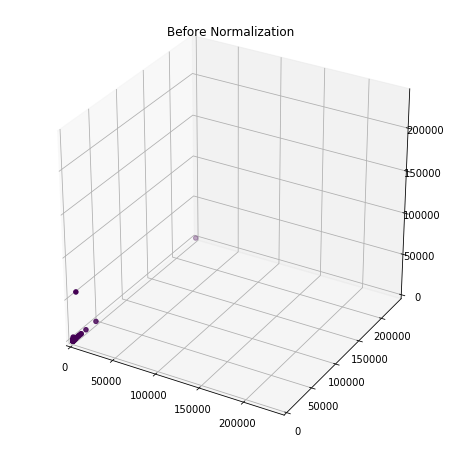

In [0]:
# Select a small portion of the data.
d_group = d.randomSplit([1, 999])[0].cache()
d_plot = d_group.collect()
d_setup = np.array([[point[i] for i in chosenF] for point in d_plot])
labels = [clusters.predict(point) for point in d_plot]

# Bounds of the graph
MAX = max(d_setup.flatten())
MIN = min(d_setup.flatten())

# plotting the clusters
fig = plt.figure(figsize = (8, 8))

# dictate that the plot will be a 3D representation of the data
# needed to install "from mpl_toolkits.mplot3d import Axes3D" in order to plot
axis = fig.add_subplot(111, projection = '3d')

axis.scatter(d_setup[:, 0], d_setup[:, 1], d_setup[:, 2], c = labels)

# set graph limits using MAX and MIN
axis.set_xlim(MIN, MAX)
axis.set_ylim(MIN, MAX)
axis.set_zlim(MIN, MAX)

# Setting plot title.
axis.set_title("Before Normalization")

Text(0.5, 0.92, 'After Normalization')

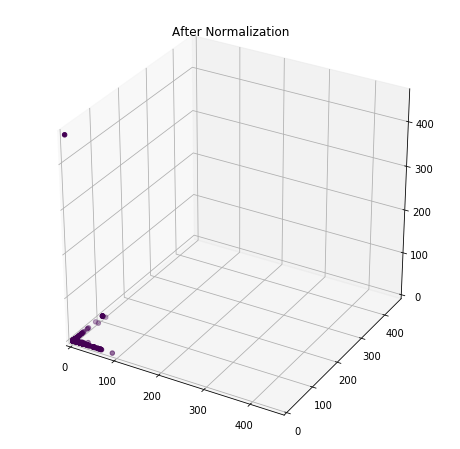

In [0]:
'''
Creating a function to work with two data sets for normalization.
'''

def normalize2Data(d, d2):
    # number of connections
    connections = d.count()
    m = d.reduce(add) / connections
    fvar = d.map(lambda x: (x - m) ** 2).reduce(add) / connections
    stdevs = np.sqrt(fvar)
    # if == 0 than = 1
    stdevs[stdevs == 0] = 1

    def normalize(point):
        return (point - m) / stdevs
    return d.map(normalize)

# Select a small portion of the data.
nd_plot = normalize2Data(d, d_group).cache()
nd_plot = nd_plot.collect()
nd_setup = np.array([[point[i] for i in chosenF] for point in nd_plot])
nlabels = [clusters.predict(point) for point in nd_plot]

# Bounds of the graph
MAX = max(nd_setup.flatten())
MIN = min(nd_setup.flatten())

# plotting the clusters
fig = plt.figure(figsize = (8, 8))

# dictate that the plot will be a 3D representation of the data
# needed to install "from mpl_toolkits.mplot3d import Axes3D" in order to plot
axis = fig.add_subplot(111, projection = '3d')
axis.scatter(nd_setup[:, 0], nd_setup[:, 1], nd_setup[:, 2], c = nlabels)

# set graph limits using MAX and MIN
axis.set_xlim(MIN, MAX)
axis.set_ylim(MIN, MAX)
axis.set_zlim(MIN, MAX)

# Setting plot title.
axis.set_title("After Normalization")

*Full Dataset*

Before normalization the data has more variance, thus manipulating and skewing the KMeans algorithm.  In the first graph we can see data values as far out as converging at 0, 0, 0, or the farthest back corner of the 3D graph.  After normalizing the data we see that this data point, and other outlires, are removed from the graph.  Now we see most of the data points clustered at the front left corner.  There remains a few outlires but compared to the original graph, which was significantly zoomed out, we now have far greater view of the data points important to our analysis.

# **2.3. Clustering using categorical features**
# **2.3.1 Loading data**
In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering. The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, substraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical features into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in  d -dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice blog post on the problem.

There are two approaches:

* **Approach 1:** mapping one categorial feature to one numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* Approach 2: mapping mapping one categorial feature to multiple numerical features. Basically, a single variable with  n  observations and  d  distinct values, to  d  binary variables with  n  observations each. Each observation indicating the presence (1) or absence (0) of the  dth  binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes
\begin{align}
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
\end{align}
We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.

# **Question 8**
Calculate the number of distinct categorical features value (at index 1,2,3). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

In [0]:
feat1 = raw_data.map(lambda line: line.split(",")[1]).distinct().collect()
feat2 = raw_data.map(lambda line: line.split(",")[2]).distinct().collect()
feat3 = raw_data.map(lambda line: line.split(",")[3]).distinct().collect()

def hotEncode(line):
  columns = line.split(',')
  label = columns[-1]
  vector = columns[0:-1]

  # From the first categorial features; binary values.
  featof1 = [0] * len(feat1)
  featof1[feat1.index(vector[1])] = 1

  # From the second categorial features; binary values.
  featof2 = [0] * len(feat2)
  featof2[feat2.index(vector[2])] = 1

  # From the third categorial features; binary values.
  featof3 = [0] * len(feat3)
  featof3[feat3.index(vector[3])] = 1

  # New vector construction
  vector = ([vector[0]] + featof1 + featof2 + 
        featof3 + vector[4:])
  # Convert string to float
  vector = np.array(vector, dtype = np.float)

  return (label, vector)

lnd = raw_data.map(hotEncode)
d = lnd.values().cache()

results = normalizeData(d).cache()

# **2.3.2. Building models**
# **Question 9**
Using the new data, cluster the connections with different values of $k\in [80,90,100,110,120,130,140,150,160]$. Evaluate the results and choose the best value of  k  as previous questions.

/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


Text(0, 0.5, 'clustering score')

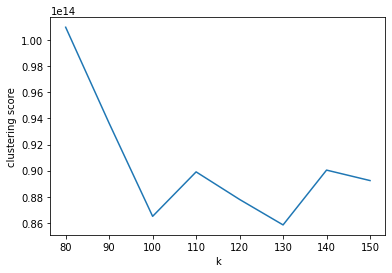

In [0]:
k_range = range(80, 160, 10)

k_check = [clusteringScore(results, k) for k in k_range]
plt.plot(k_range, k_check)
plt.xlabel('k')
plt.ylabel('clustering score')

*Full Dataset*

This took a significant time to run, but once it completed there appeared to be a clear global minimum of 130.  To pick the exact point, which may be around the 130 value, runs with lower iterations may be valuable.  I will not be doing this at this time, as this will take too much computational power for the current testing environment.



# **2.4. Anomaly detection**
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide wheter there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

# **Question 10**
Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

HINT: The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


Text(0, 0.5, 'clustering score')

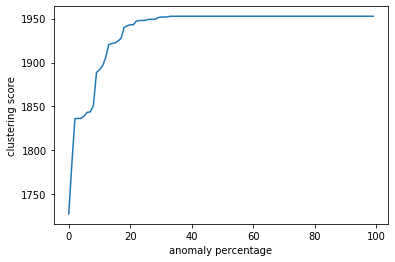

In [0]:
clusters = KMeans.train(d, 130, maxIterations = 10, runs = 10, initializationMode = "random")

anom = results.map(lambda point: (point, error(clusters, point))).takeOrdered(100, lambda key: key[1])
plt.plot([anomaly[1] for anomaly in anom])
plt.xlabel('anomaly percentage')
plt.ylabel('clustering score')

*Full Dataset*

This looks similar to a maximum elbow for finding K-means values.  There are few distinct levels where data levels off.  Two small areas appear around cluster score 3455 and above 3465.  The flatest value appears to be 3470.  

For the three distinct levels identified, all appear to be under 20% regarding anomalous connections.  meaning that using K means value 130 appears to lead to a 20% chance of anomalous connections at most based on this data set.

*Full Dataset Update*

After running this again, a beter review of the data is shown (now visible above in the notebook).  This shows leveling off around 1840, 1925, and 1950.  Now there are other, smaller levels which do not flatten out enough to mark in these notes.

Again, other than small differences in the line, most anomalies appear to be under 20%.  As such, it still appears that k = 130 is a good k-means value.